# Fit halo mass to shear profile: 1. ideal data

_the LSST-DESC CLMM team_


This notebook demonstrates how to use `clmm` to estimate a WL halo mass of a galaxy cluster in the ideal case: i) all galaxies on a single source plane, ii) no redshift errors, iii) no shape noise. The steps below correspond to:
- Setting things up, with the proper imports.
- Generating a ideal mock dataset.
- Computing the binned reduced tangential shear profile, for two different binning scheme.
- Setting up the model to be fitted to the data.
- Perform a simple fit using `scipy.optimize.basinhopping` and visualize the results.

## Setup

First, we import some standard packages.

In [1]:
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import numpy as np
import matplotlib.pyplot as plt

from numpy import random

Next, we import `clmm`'s core modules.

In [2]:
import clmm
import clmm.dataops as da
import clmm.galaxycluster as gc
import clmm.theory as theory
from clmm import Cosmology

Make sure we know which version we're using

In [3]:
clmm.__version__

'1.0.8'

We then import a support modules for a specific data sets.
`clmm` includes support modules that enable the user to generate mock data in a format compatible with `clmm`.
We also provide support modules for processing other specific data sets for use with `clmm`.
Any existing support module can be used as a template for creating a new support module for another data set.
If you do make such a support module, please do consider making a pull request so we can add it for others to use.

## Making mock data

In [4]:
from clmm.support import mock_data as mock

In [5]:
np.random.seed(11)

To create mock data, we need to define a true cosmology.

In [6]:
mock_cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

We now set some parameters for a mock galaxy cluster.

In [7]:
cosmo = mock_cosmo
cluster_id = "Awesome_cluster"
cluster_m = 1.e15 # M200,m [Msun]
cluster_z = 0.3
src_z = 0.8
concentration = 4
ngals = 10000
cluster_ra = 0.0
cluster_dec = 0.0

Then we use the `mock_data` support module to generate a new galaxy catalog.

In [8]:
ideal_data = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration,
                                          cosmo, src_z, ngals=ngals)

This galaxy catalog is then converted to a `clmm.GalaxyCluster` object.

In [9]:
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                               cluster_z, ideal_data)

A `clmm.GalaxyCluster` object can be pickled and saved for later use.

In [10]:
gc_object.save('mock_GC.pkl')

Any saved `clmm.GalaxyCluster` object may be read in for analysis.

In [11]:
cl = clmm.GalaxyCluster.load('mock_GC.pkl')
print("Cluster info = ID:", cl.unique_id, "; ra:", cl.ra, "; dec:", cl.dec,
      "; z_l :", cl.z)
print("The number of source galaxies is :", len(cl.galcat))

ra_l = cl.ra
dec_l = cl.dec
z = cl.z
e1 = cl.galcat['e1']
e2 = cl.galcat['e2']
ra_s = cl.galcat['ra']
dec_s = cl.galcat['dec']
z_s = cl.galcat['z']

Cluster info = ID: Awesome_cluster ; ra: 0.0 ; dec: 0.0 ; z_l : 0.3
The number of source galaxies is : 10000


We can visualize the distribution of galaxies on the sky.

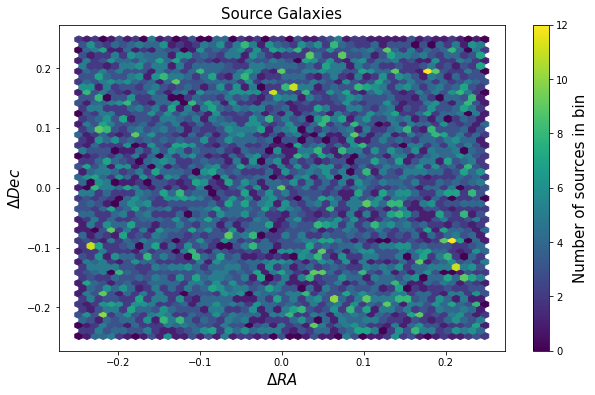

In [12]:
fsize = 15

fig = plt.figure(figsize=(10, 6))
hb = fig.gca().hexbin(ra_s, dec_s, gridsize=50)

cb = fig.colorbar(hb)
cb.set_label('Number of sources in bin', fontsize=fsize)

plt.gca().set_xlabel(r'$\Delta RA$', fontsize=fsize)
plt.gca().set_ylabel(r'$\Delta Dec$', fontsize=fsize)
plt.gca().set_title('Source Galaxies', fontsize=fsize)

plt.show()

`clmm` separates cosmology-dependent and cosmology-independent functionality.

## Deriving observables

We first demonstrate a few of the procedures one can perform on data without assuming a cosmology.

### Computing shear

`clmm.dataops.compute_tangential_and_cross_components` calculates the tangential and cross shears for each source galaxy in the cluster.

In [13]:
theta, g_t, g_x = da.compute_tangential_and_cross_components(ra_l, dec_l, ra_s, dec_s, e1, e2, geometry="flat")

We can visualize the shear field at each galaxy location.

Text(0.5, 0, 'angular distance [rad]')

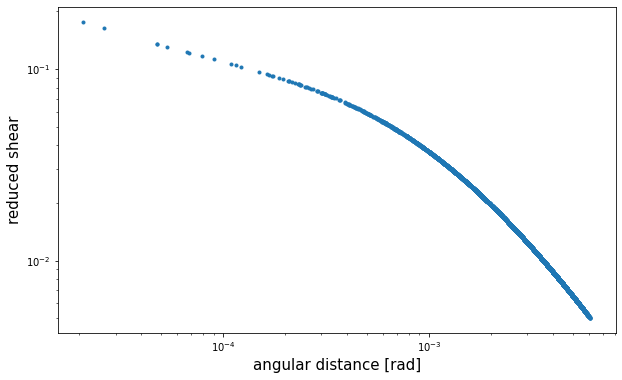

In [14]:
fig = plt.figure(figsize=(10, 6))

fig.gca().loglog(theta, g_t, '.')
plt.ylabel("reduced shear", fontsize=fsize)
plt.xlabel("angular distance [rad]", fontsize=fsize)

### Radially binning the data

Here we compare the reconstructed mass under two different bin definitions. 

Note binning would cause fitted mass to be slightly larger than input mass. The reason is that g(r), the tangential reduced shear along cluster radius, is a convex function -- the function value after binning would be larger, but the bias becomes smaller as bin number increases.

In [15]:
bin_edges1 = da.make_bins(0.01, 3.7, 50)
bin_edges2 = da.make_bins(0.01, 3.7, 10)

`clmm.dataops.make_radial_profile` evaluates the average shear of the galaxy catalog in bins of radius.

In [16]:
res1 = da.make_radial_profile(
    [g_t, g_x, z_s], theta, "radians", "Mpc", bins=bin_edges1, cosmo=cosmo, z_lens=z, include_empty_bins=False)
res2 = da.make_radial_profile(
    [g_t, g_x, z_s], theta, "radians", "Mpc", bins=bin_edges2, cosmo=cosmo, z_lens=z, include_empty_bins=False)

/Users/combet/anaconda3/envs/clmmenv/lib/python3.8/site-packages/clmm-1.0.8-py3.8.egg/clmm/utils.py:68: RuntimeWarning: invalid value encountered in sqrt


Note that we set `include_empty_bins=False` explicitly here even though it is the default behavior. Setting the argument to `True` would also return empty bins (that is, bins with *at most one* data point in them), which would have to be excluded manually when fitting, though it might be useful e.g., when combining datasets. To clarify the behavior, consider the following comparison:

In [17]:
res_with_empty = da.make_radial_profile(
    [g_t, g_x, z_s], theta, "radians", "Mpc", bins=1000, cosmo=cosmo, z_lens=z, include_empty_bins=True)
# this is the default behavior
res_without_empty = da.make_radial_profile(
    [g_t, g_x, z_s], theta, "radians", "Mpc", bins=1000, cosmo=cosmo, z_lens=z, include_empty_bins=False)
res_with_empty['n_src'].size, res_without_empty['n_src'].size

(1000, 892)

i.e., 108 bins have fewer than two sources in them and are excluded by default (when setting the random seed to 11).

For later use, we'll define some variables for the binned radius and tangential shear.

In [18]:
gt_profile1 = res1['p_0']
r1 = res1['radius']
z1 = res1['p_2']

gt_profile2 = res2['p_0']
r2 = res2['radius']
z2 = res2['p_2']

We visualize the radially binned shear for our mock galaxies.

Text(0, 0.5, '$g_t$')

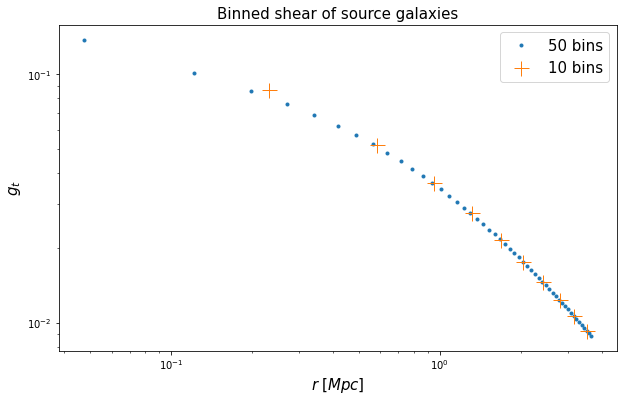

In [19]:
fig = plt.figure(figsize=(10, 6))

fig.gca().loglog(r1, gt_profile1, '.', label='50 bins')
fig.gca().loglog(r2, gt_profile2, '+', markersize=15, label='10 bins')
plt.legend(fontsize=fsize)

plt.gca().set_title(r'Binned shear of source galaxies', fontsize=fsize)
plt.gca().set_xlabel(r'$r\;[Mpc]$', fontsize=fsize)
plt.gca().set_ylabel(r'$g_t$', fontsize=fsize)

You can also run `make_radial_profile` direct on a `clmm.GalaxyCluster` object.

In [20]:
cl.compute_tangential_and_cross_components() # You need to add the shear components first
cl.make_radial_profile("Mpc", bins=1000, cosmo=cosmo, include_empty_bins=False)
pass

/Users/combet/anaconda3/envs/clmmenv/lib/python3.8/site-packages/clmm-1.0.8-py3.8.egg/clmm/utils.py:68: RuntimeWarning: invalid value encountered in sqrt


After running `clmm.GalaxyCluster.make_radial_profile` object, the object acquires the `clmm.GalaxyCluster.profile` attribute.

In [21]:
for n in cl.profile.colnames: cl.profile[n].format = "%6.3e"
cl.profile.pprint(max_width=-1)

radius_min   radius  radius_max     gt      gt_err      gx       gx_err      z       z_err     n_src  
---------- --------- ---------- --------- --------- ---------- --------- --------- --------- ---------
 1.929e-02 2.182e-02  2.490e-02 1.699e-01 4.854e-03 -1.670e-11 1.889e-12 8.000e-01 0.000e+00 2.000e+00
 4.172e-02 4.415e-02  4.733e-02 1.354e-01 7.376e-05 -4.715e-11 5.896e-12 8.000e-01 0.000e+00 2.000e+00
 5.855e-02 6.252e-02  6.416e-02 1.224e-01 2.610e-04  2.779e-11 3.953e-11 8.000e-01 0.000e+00 2.000e+00
 1.595e-01 1.611e-01  1.651e-01 9.224e-02 7.363e-05 -3.827e-10 2.051e-10 8.000e-01 0.000e+00 2.000e+00
 1.931e-01 1.937e-01  1.987e-01 8.657e-02 3.080e-05  4.157e-11 5.475e-10 8.000e-01 0.000e+00 2.000e+00
 2.100e-01 2.141e-01  2.156e-01 8.349e-02 9.282e-05  3.166e-10 6.021e-10 8.000e-01 0.000e+00 2.000e+00
 2.156e-01 2.186e-01  2.212e-01 8.283e-02 1.114e-04  1.473e-10 1.915e-10 8.000e-01 0.000e+00 3.000e+00
 2.324e-01 2.357e-01  2.380e-01 8.049e-02 8.085e-05  1.168e-09 9.636e-11 

## Modeling the data

We next demonstrate a few of the procedures one can perform once a cosmology has been chosen.

### Choosing a halo model

In [22]:
def nfw_to_shear_profile(logm, profile_info):
    [r, gt_profile, z_src_rbin] = profile_info
    m = 10.**logm
    gt_model = clmm.compute_reduced_tangential_shear(r,
                                                     m, concentration,
                                                     cluster_z, z_src_rbin, cosmo,
                                                     delta_mdef=200,
                                                     halo_profile_model='nfw')
    return np.sum((gt_model - gt_profile)**2)

### Fitting a halo mass

We optimize to find the best-fit mass for the data under the two radial binning schemes.

In [23]:
from clmm.support.sampler import samplers

Note: The samplers['minimize'] is a local optimization function, so it does not guarantee to give consistent results (logm_est1 and logm_est2) for all logm_0, which is dependent on the np.random.seed(#) set previously. Some choices of np.random.seed(#) (e.g. set # to 1) will output a logm_0 that leads to a much larger logm_est and thus a misbehaving best-fit model. In contrast, the samplers['basinhopping'] is a global optimization function, which can give stable results regardless of the initial guesses, logm_0. Since its underlying method is the same as the samplers['minimize'], the two functions take the same arguments.

In [29]:
logm_0 = random.uniform(13., 17., 1)[0]

#logm_est1 = samplers['minimize'](nfw_to_shear_profile, logm_0,args=[r1, gt_profile1, z1])[0]
logm_est1 = samplers['basinhopping'](nfw_to_shear_profile, logm_0, minimizer_kwargs={'args': ([r1, gt_profile1, z1])})[0]

#logm_est2 = samplers['minimize'](nfw_to_shear_profile, logm_0,args=[r2, gt_profile2, z2])[0]
logm_est2 = samplers['basinhopping'](nfw_to_shear_profile, logm_0, minimizer_kwargs={'args': ([r2, gt_profile2, z2])})[0]

m_est1 = 10.**logm_est1
m_est2 = 10.**logm_est2

print((m_est1, m_est2))

TypeError: mdelta must be <class 'float'>, received ndarray

In [28]:
logm_0

13.336753154306956

In [26]:
logm_est1

NameError: name 'logm_est1' is not defined

Next, we calculate the reduced tangential shear predicted by the two models.

In [ ]:
rr = np.logspace(-2, np.log10(5), 100)

gt_model1 = clmm.compute_reduced_tangential_shear(rr,
                                                  m_est1, concentration,
                                                  cluster_z, src_z, cosmo,
                                                  delta_mdef=200,
                                                  halo_profile_model='nfw')

gt_model2 = clmm.compute_reduced_tangential_shear(rr,
                                                  m_est2, concentration,
                                                  cluster_z, src_z, cosmo,
                                                  delta_mdef=200,
                                                  halo_profile_model='nfw')

We visualize the two predictions of reduced tangential shear.

In [ ]:
fig = plt.figure(figsize=(10, 6))

fig.gca().scatter(r1, gt_profile1, color='orange',
                  label='binned mock data 1, M_input = %.3e Msun' % cluster_m)
fig.gca().plot(rr, gt_model1, color='orange',
               label='best fit model 1, M_fit = %.3e' % m_est1)

fig.gca().scatter(r2, gt_profile2, color='blue', alpha=0.5,
                  label='binned mock data 2, M_input = %.3e Msun' % cluster_m)
fig.gca().plot(rr, gt_model2, color='blue', linestyle='--', alpha=0.5,
               label='best fit model 2, M_fit = %.3e' % m_est2)

plt.semilogx()
plt.semilogy()

plt.legend()
plt.xlabel('R [Mpc]', fontsize=fsize)
plt.ylabel('reduced tangential shear', fontsize=fsize)